In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer
from prophet import Prophet
import plotly.graph_objects as go

# Carregar e preparar os dados
df = pd.read_csv('transacaoCartao.csv', sep=';', decimal=',')
df['datatrimestre'] = pd.to_datetime(df['datatrimestre'])

c:\Users\airon\OneDrive\Documentos\SENAC\III MODULO\DATA SCIENSE\etlBCB\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Corrigir formato numérico

In [2]:
for col in df.columns:
    if col.startswith('valor'):
        df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df[col] = df[col].astype(float)

df = df.sort_values('datatrimestre')

# Análise para valorConvenios

In [3]:
print("\n=== ANÁLISE EXPLORATÓRIA PARA valorConvenios ===\n")


=== ANÁLISE EXPLORATÓRIA PARA valorConvenios ===



# 1. Estatísticas descritivas

In [4]:
print("Estatísticas Descritivas:")
print(df['valorConvenios'].describe())

Estatísticas Descritivas:
count    2.400000e+01
mean     8.432920e+12
std      1.514865e+12
min      4.809874e+12
25%      7.125069e+12
50%      9.002542e+12
75%      9.395803e+12
max      1.079005e+13
Name: valorConvenios, dtype: float64


# 2. Distribuição e outliers

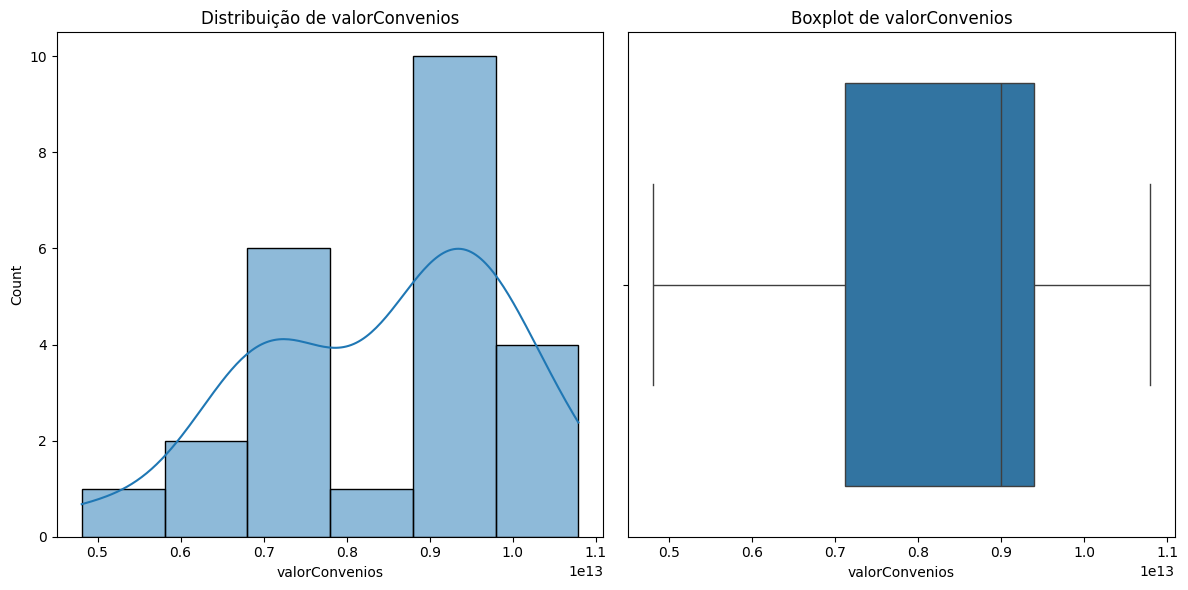

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['valorConvenios'], kde=True)
plt.title('Distribuição de valorConvenios')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['valorConvenios'])
plt.title('Boxplot de valorConvenios')
plt.tight_layout()
plt.show()

# 3. Série temporal

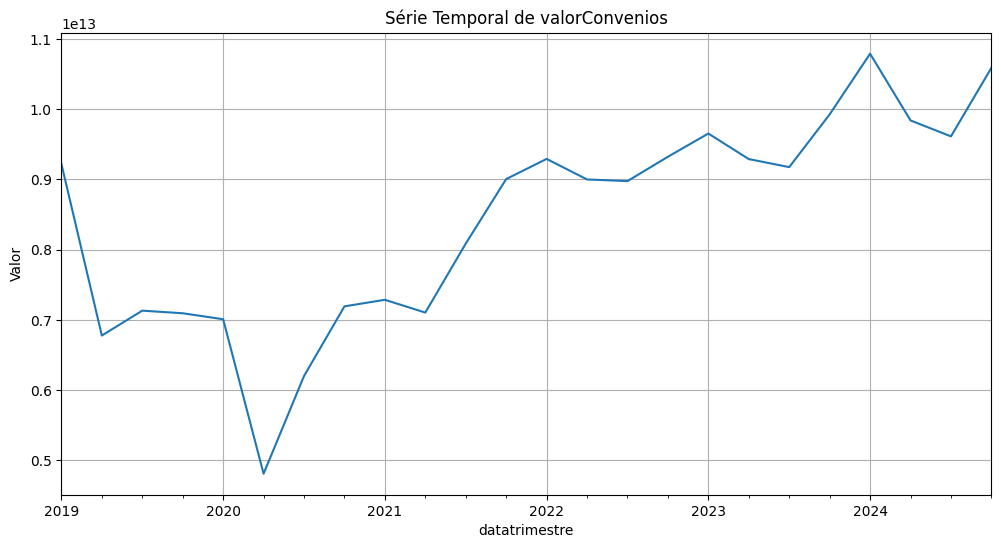

In [6]:
plt.figure(figsize=(12, 6))
df.set_index('datatrimestre')['valorConvenios'].plot()
plt.title('Série Temporal de valorConvenios')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# 4. Análise de correlação

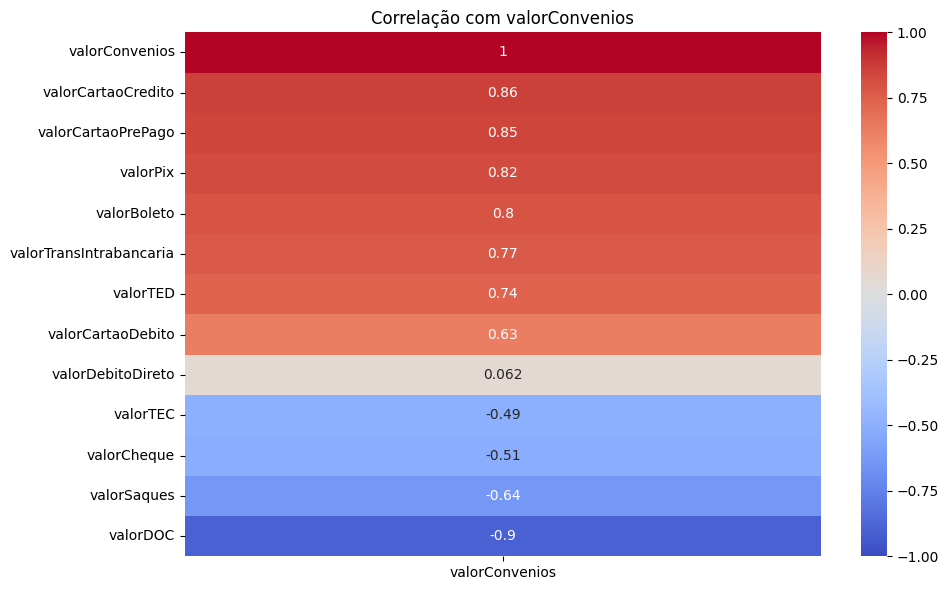

In [7]:
correlacao = df[[col for col in df.columns if col.startswith('valor')]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlacao[['valorConvenios']].sort_values(by='valorConvenios', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlação com valorConvenios')
plt.tight_layout()
plt.show()

# MODELO 1: RANDOM FOREST OPTIMIZADO ========================================

In [8]:
print("\n=== MODELO RANDOM FOREST OPTIMIZADO ===\n")


=== MODELO RANDOM FOREST OPTIMIZADO ===



# Preparar dados

In [9]:
X_rf = df.drop(columns=['valorConvenios', 'datatrimestre'])
y_rf = df['valorConvenios']

# Transformação para normalizar a variável alvo

In [10]:
transformer = PowerTransformer(method='yeo-johnson')
y_transformed = transformer.fit_transform(y_rf.values.reshape(-1, 1))
y_rf = pd.Series(y_transformed.flatten(), name='valorConvenios')

# Feature Importance inicial

In [13]:
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_rf, y_rf)
importancias = pd.Series(model_temp.feature_importances_, index=X_rf.columns)
melhores_variaveis = importancias.sort_values(ascending=False).head(8).index.tolist()

# Criar lags para séries temporais

In [14]:
df['lag1'] = df['valorConvenios'].shift(1)
df['lag2'] = df['valorConvenios'].shift(2)
df = df.dropna()

# Dataset final

In [15]:
X_final = df[melhores_variaveis + ['lag1', 'lag2']]
y_final = df['valorConvenios']

# Transformar y_final também

In [16]:
y_final_transformed = transformer.transform(y_final.values.reshape(-1, 1)).flatten()

# Split temporal (não shuffle para séries temporais)

In [17]:
train_size = int(len(X_final) * 0.7)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_final_transformed[:train_size], y_final_transformed[train_size:]

# Otimização de hiperparâmetro

In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

# Melhor modelo

In [19]:
best_rf = grid_search.best_estimator_
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

Melhores parâmetros encontrados:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# Previsões

In [20]:
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Reverter transformação

In [21]:
y_train_inv = transformer.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_inv = transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_train_inv = transformer.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test_inv = transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

# Métricas

In [22]:
print("\nMétricas de avaliação (TESTE):")
print(f"- RMSE: {np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv)):,.2f}")
print(f"- MAE: {mean_absolute_error(y_test_inv, y_pred_test_inv):,.2f}")
print(f"- R²: {r2_score(y_test_inv, y_pred_test_inv):.2f}")


Métricas de avaliação (TESTE):
- RMSE: 715,641,309,763.42
- MAE: 541,610,108,692.85
- R²: -0.59


# Visualização

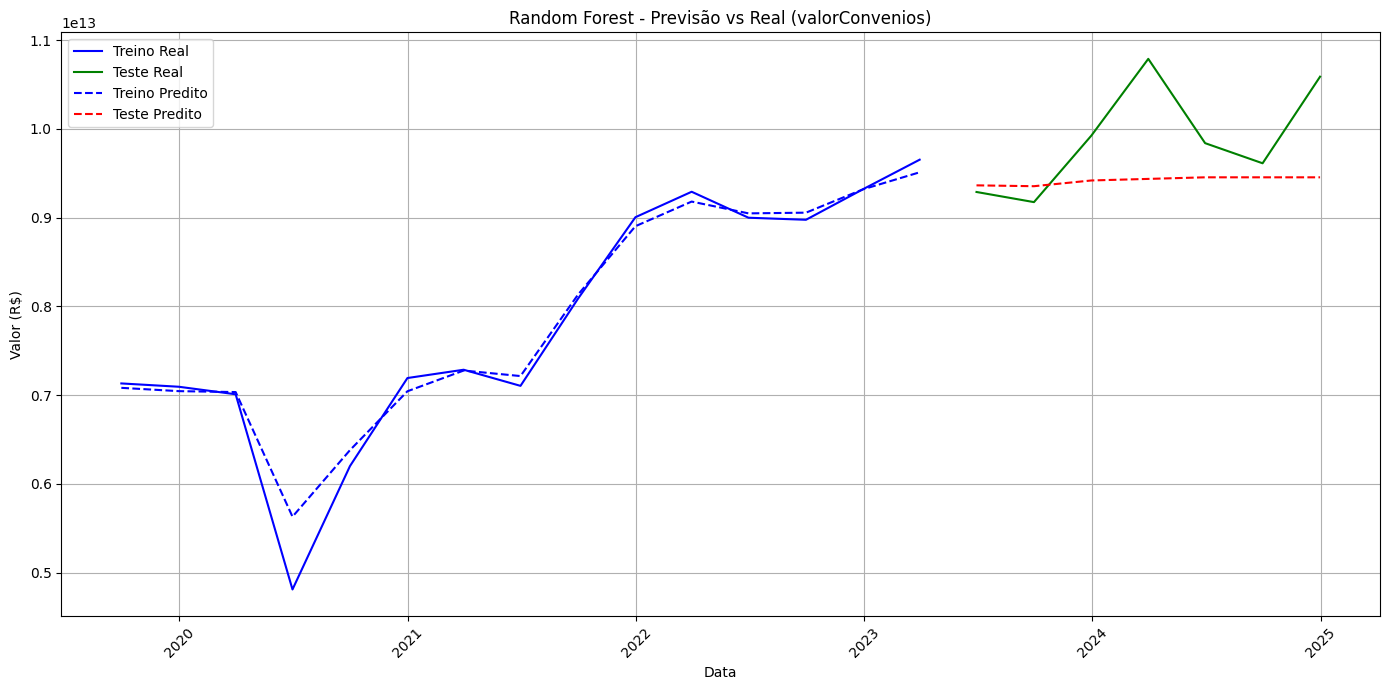

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(df['datatrimestre'][:len(y_train_inv)], y_train_inv, label='Treino Real', color='blue')
plt.plot(df['datatrimestre'][len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, 
         label='Teste Real', color='green')
plt.plot(df['datatrimestre'][:len(y_train_inv)], y_pred_train_inv, 
         label='Treino Predito', color='blue', linestyle='--')
plt.plot(df['datatrimestre'][len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_pred_test_inv, 
         label='Teste Predito', color='red', linestyle='--')
plt.title('Random Forest - Previsão vs Real (valorConvenios)')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()